<font size="6"> **ML-Sentiment Factor in SEC 10-K Fillings** </font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

In [3]:
import nltk
import numpy as np
import pandas as pd
import scipy
import pickle
import datetime as dt

import os

from tqdm import tqdm

In [4]:
from src import utils
from src.load_data import load_sec10k, io_utils
from src.nlp_quant import bow_sent

In [5]:
cfg = utils.read_conf()

In [6]:
INPATH1 = os.path.join(io_utils.interim_path, 'sec_fillings', '')
INPATH2 = os.path.join(io_utils.raw_path, 'market_data', cfg['quantopian']['dataset4']['folder'],'')
os.path.isdir(INPATH1), os.path.isdir(INPATH2)

(True, True)

In [7]:
INFILE1 = 'metadata.pkl'
INFILE2 = 'tenks_risk_tfidf_by_sent.pkl'
INFILE3 =  'parsed_sentiment_loughran_mcdonald.csv'
INFILE4 =  'tenks_risk_doc_len.csv'
INFILE5 = cfg['quantopian']['dataset4']['prices']
INFILE6 = cfg['output']['interim']['sector_factors']

In [8]:
OUTPATH =  os.path.join(io_utils.processed_path, 'sec_fillings', '')
os.path.isdir(OUTPATH)

True

In [9]:
OUTFILE1 = 'sec_10k_mlbow_sent_alpha.csv'

In [10]:
example_ticker = 'amzn'

In [11]:
START_DT = '1998'
END_DT = '2018'
train_test_split_yr = '2016'
KFOLDS = 3

# Load Data

In [12]:
with open(INPATH1 + INFILE1, 'rb') as file:
    metadata = pickle.load(file)

In [13]:
tf_idf_by_sent = bow_sent.read_sent_tfidf_dict(path=INPATH1, name=INFILE2)

In [14]:
tf_idf_by_sent.keys()

dict_keys(['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting'])

In [15]:
tf_idf_by_sent['negative'].iloc[0:2,0:10]

abandon  abandonment  abandonments  abdicate  abdication  \
ticker date                                                                   
aal    2003-04-15      0.0          0.0           0.0       0.0         0.0   
       2004-02-27      0.0          0.0           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
ticker date                                                          
aal    2003-04-15          0.0       0.0         0.0           0.0   
       2004-02-27          0.0       0.0         0.0           0.0   

                   aberrations  
ticker date                     
aal    2003-04-15          0.0  
       2004-02-27          0.0

In [16]:
tf_idf_by_sent['negative'].iloc[:5,0]  # underlying pandas is an sparse data structure

ticker  date      
aal     2003-04-15    0.0
        2004-02-27    0.0
        2005-02-25    0.0
        2006-02-24    0.0
        2007-02-23    0.0
Name: abandon, dtype: Sparse[float64, 0.0]

In [17]:
doc_lens = pd.read_csv(INPATH1 + INFILE4, parse_dates=['date'], index_col=[0,1])['doc_len']

In [18]:
sentiment_df =  pd.read_csv(INPATH1 + INFILE3)

In [19]:
# Yearly pricing
pricing_yr = pd.read_csv(INPATH2 + INFILE5, parse_dates=['date'])
pricing_yr = pricing_yr.pivot(index='date', columns='ticker', values='adj_close')
pricing_yr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 1962-01-01 to 2018-01-01
Columns: 11941 entries, A to ZZZ
dtypes: float64(11941)
memory usage: 5.2 MB


In [20]:
pd.concat([pricing_yr.head(2), pricing_yr.tail(2)], axis=0)

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,AAPC,AAPL,AAT,AAU,AAV,AAVL,AAWW,AAXJ,AAXN,AA_P_B,AA_W,...,ZOES,ZOM,ZOOM,ZPIN,ZQK,ZROZ,ZS,ZSAN,ZSL,ZSML,ZSPH,ZTO,ZTR,ZTS,ZU,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1962-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,66.653918,53.87,81.62,69.85,9.00,58.835707,NaN,51.803585,81.6,3.378882,39.797356,37.82,36.522919,99.593649,10.6,167.90118,37.654925,1.03,4.3,NaN,58.65,75.858764,26.50,NaN,NaN,...,16.72,1.9771,NaN,18.2,NaN,120.593382,NaN,10.40,31.40,26.9,NaN,15.641173,12.643875,71.815333,NaN,20.825,NaN,100.1,NaN,1.2165,NaN,7.5931,12.52,25.0,0.01
2018-01-01,61.800000,46.88,81.63,73.35,9.81,52.880000,NaN,37.990000,67.9,2.575000,43.740000,46.00,35.250000,135.860000,NaN,185.40000,38.860000,0.71,3.1,NaN,71.45,70.250000,64.98,NaN,NaN,...,10.16,2.2100,NaN,NaN,NaN,115.750000,36.67,4.68,34.91,NaN,NaN,19.450000,11.450000,86.150000,NaN,24.300,26.74,NaN,NaN,1.3800,NaN,15.3400,9.17,NaN,NaN


In [21]:
SECTOR_FOLDER = cfg['quantopian']['dataset1']['sector_folder']
SECTOR_NAMES = cfg['quantopian']['dataset1']['sector_names']

# Specify the bundle path
sector_file = os.path.join(io_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_NAMES)

In [22]:
sector_names = pd.read_csv(sector_file, usecols=['Sector', 'sector_id'], index_col='sector_id')
sector_names.loc[-1, 'Sector'] = 'No sector'
sector_names = sector_names.drop_duplicates()

sector_names

,Sector
sector_id,
0,Healthcare
1,Technology
2,Consumer Defensive
3,Industrials
4,Utilities
5,Financial Services
6,Real Estate
7,Communication Services
8,Consumer Cyclical


In [23]:
sector_factor_df = pd.read_csv(io_utils.interim_path + INFILE6, parse_dates=['date'], index_col=[0,1])

sector_factor_df = sector_factor_df.reset_index().merge(sector_names, how='left', left_on='sector_code', right_index=True).\
    set_index(keys=['date', 'asset'])[['sector_code', 'Sector']]
sector_factor_df.columns = ['sector_code', 'sector']

pd.concat([sector_factor_df.head(2), sector_factor_df.tail(2)], axis=0)

sector_code              sector
date                      asset                                 
2013-01-03 00:00:00+00:00 A                0          Healthcare
                          AAL              3         Industrials
2015-12-28 00:00:00+00:00 ZION             5  Financial Services
                          ZTS              0          Healthcare

In [24]:
# Mapping from asset to sector (no date)
sector_to_asset = sector_factor_df.reset_index('asset').drop_duplicates().set_index('asset')
sector_to_asset.index = pd.Index([x.lower() for x in sector_to_asset.index], name='ticker')

pd.concat([sector_to_asset.head(2), sector_to_asset.tail(2)], axis=0)

,sector_code,sector
ticker,,
a,0,Healthcare
aal,3,Industrials
hpe,1,Technology
csra,1,Technology


# Compute TF-IDF matrix bsed on Loughran Mcdonald textual analysis in financial data



In [25]:
sentiments = sentiment_df.columns.tolist()[:-1]
sentiments

['negative',
 'positive',
 'uncertainty',
 'litigious',
 'constraining',
 'interesting']

In [26]:
sentiment_df.shape # complete vocab size

(2719, 7)

In [27]:
word_vocab = pd.Series(index=sentiment_df['word'].values, data=sentiment_df.sum(axis=1).values )
word_vocab[word_vocab>1]  # tokens that appear in more than one sentiment

abrogate       2
abrogation     2
abrogations    2
acquit         2
acquittal      2
              ..
violative      2
void           2
volatile       2
volatility     2
willfully      2
Length: 144, dtype: int64

In [28]:
tfidf = bow_sent.get_combined_tfidf(tf_idf_by_sent)
tfidf.index = pd.MultiIndex.from_tuples([(ticker, dt.date(year=date.year, month=1, day=1)) for ticker, date in tfidf.index], names=tfidf.index.names )

pd.concat([tfidf.head(2), tfidf.tail(2)], axis=0)

Number of removed words:
uncertainty: 32
litigious: 95
constraining: 18
interesting: 2


abandon  abandonment  abandonments  abdicate  abdication  \
ticker date                                                                    
aal    2003-01-01  0.000000     0.000000           0.0       0.0         0.0   
       2004-01-01  0.000000     0.000000           0.0       0.0         0.0   
zts    2019-01-01  0.012278     0.013347           0.0       0.0         0.0   
       2020-01-01  0.013254     0.014408           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
ticker date                                                          
aal    2003-01-01          0.0       0.0         0.0           0.0   
       2004-01-01          0.0       0.0         0.0           0.0   
zts    2019-01-01          0.0       0.0         0.0           0.0   
       2020-01-01          0.0       0.0         0.0           0.0   

                   aberrations  abet  abnormal  abnormalities  abnormality  \
ticker date                                                                  
aal    2003-01-01          0.0   0.0       0.0            0.0          0.0   
       2004-01-01          0.0   0.0       0.0            0.0          0.0   
zts    2019-01-01          0.0   0.0       0.0            0.0          0.0   
       2020-01-01          0.0   0.0       0.0            0.0          0.0   

                   abnormally  abolish  abrogate  abrogation  abrogations  \
ticker date                                                                 
aal    2003-01-01         0.0      0.0       0.0         0.0          0.0   
       2004-01-01         0.0      0.0       0.0         0.0          0.0   
zts    2019-01-01         0.0      0.0       0.0         0.0          0.0   
       2020-01-01         0.0      0.0       0.0         0.0          0.0   

                   abrupt  abruptly  abruptness   absence  absences  \
ticker date                                                           
aal    2003-01-01     0.0       0.0         0.0  0.033477       0.0   
       2004-01-01     0.0       0.0         0.0  0.000000       0.0   
zts    2019-01-01     0.0       0.0         0.0  0.000000       0.0   
       2020-01-01     0.0       0.0         0.0  0.000000       0.0   

                   absenteeism  ...  malignant     march  mighty  mortgagee  \
ticker date                     ...                                           
aal    2003-01-01          0.0  ...        0.0  0.315236     0.0        0.0   
       2004-01-01          0.0  ...        0.0  0.385279     0.0        0.0   
zts    2019-01-01          0.0  ...        0.0  0.173299     0.0        0.0   
       2020-01-01          0.0  ...        0.0  0.184606     0.0        0.0   

                   oink  piracy  rabbi  reductions   relieve  remedial  \
ticker date                                                              
aal    2003-01-01   0.0     0.0    0.0    0.183164  0.000000  0.097192   
       2004-01-01   0.0     0.0    0.0    0.264436  0.000000  0.000000   
zts    2019-01-01   0.0     0.0    0.0    0.017230  0.000000  0.000000   
       2020-01-01   0.0     0.0    0.0    0.021107  0.028421  0.000000   

                   repossess  secret  seizures  soar  sputter  sublessee  \
ticker date                                                                
aal    2003-01-01        0.0     0.0       0.0   0.0      0.0        0.0   
       2004-01-01        0.0     0.0       0.0   0.0      0.0        0.0   
zts    2019-01-01        0.0     0.0       0.0   0.0      0.0        0.0   
       2020-01-01        0.0     0.0       0.0   0.0      0.0        0.0   

                   sublessees  sublessor  suspenders  sustainability  touche  \
ticker date                                                                    
aal    2003-01-01         0.0        0.0         0.0             0.0     0.0   
       2004-01-01         0.0        0.0         0.0             0.0     0.0   
zts    2019-01-01         0.0        0.0         0.0          

In [29]:
tfidf.shape

(8637, 2719)

In [30]:
pricing_yr.columns = [x.lower() for x in pricing_yr.columns]
targets_yr = pricing_yr.pct_change().shift(-1).stack().loc[pd.Timestamp(START_DT):]
targets_yr.name = '1yr_fwd_rets'
targets_yr.index.rename(inplace=True, level=1, names='ticker')
targets_yr

date        ticker
1998-01-01  aaba      2.653018
            aame     -0.525538
            aan       0.224597
            aaon      0.544078
            aapl      1.511236
                        ...   
2017-01-01  zxyz_a    0.000000
            zyme      1.020255
            zyne     -0.267572
            zzk       0.000000
            zzz       0.000000
Name: 1yr_fwd_rets, Length: 111116, dtype: float64

In [31]:
aapl_prices = pricing_yr.loc['2017':'2018', 'aapl']
aapl_prices

date
2017-01-01    167.90118
2018-01-01    185.40000
Name: aapl, dtype: float64

In [32]:
(aapl_prices.iloc[-1] - aapl_prices.iloc[0]) / aapl_prices.iloc[0]

0.10422094647492033

In [33]:
(pricing_yr.loc['2017', 'aapl'].values - pricing_yr.loc['2018', 'aapl'].values) / pricing_yr.loc['2017', 'aapl'].values

array([-0.10422095])

In [34]:
(pricing_yr.loc['2018', 'aapl'].values - pricing_yr.loc['2017', 'aapl'].values) / pricing_yr.loc['2017', 'aapl'].values

array([0.10422095])

In [35]:
targets_yr.loc[pd.Timestamp('2017'), 'aapl']

0.10422094647492042

In [36]:
pricing_yr.pct_change(-1).loc['2017', 'aapl']

date
2017-01-01   -0.094384
Name: aapl, dtype: float64

In [37]:
join_cols = ['date', 'ticker']
tfidf_targets = tfidf.merge(targets_yr, how='inner', on=join_cols).sort_index()

pd.concat([tfidf_targets.head(2), tfidf_targets.tail(2)], axis=0)

abandon  abandonment  abandonments  abdicate  abdication  \
date       ticker                                                              
1998-01-01 abt     0.000000     0.000000           0.0       0.0         0.0   
           adbe    0.000000     0.000000           0.0       0.0         0.0   
2017-01-01 zion    0.000000     0.000000           0.0       0.0         0.0   
           zts     0.010714     0.011646           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
date       ticker                                                    
1998-01-01 abt             0.0       0.0         0.0           0.0   
           adbe            0.0       0.0         0.0           0.0   
2017-01-01 zion            0.0       0.0         0.0           0.0   
           zts             0.0       0.0         0.0           0.0   

                   aberrations  abet  abnormal  abnormalities  abnormality  \
date       ticker                                                            
1998-01-01 abt             0.0   0.0       0.0            0.0          0.0   
           adbe            0.0   0.0       0.0            0.0          0.0   
2017-01-01 zion            0.0   0.0       0.0            0.0          0.0   
           zts             0.0   0.0       0.0            0.0          0.0   

                   abnormally  abolish  abrogate  abrogation  abrogations  \
date       ticker                                                           
1998-01-01 abt            0.0      0.0       0.0         0.0          0.0   
           adbe           0.0      0.0       0.0         0.0          0.0   
2017-01-01 zion           0.0      0.0       0.0         0.0          0.0   
           zts            0.0      0.0       0.0         0.0          0.0   

                   abrupt  abruptly  abruptness   absence  absences  \
date       ticker                                                     
1998-01-01 abt        0.0       0.0         0.0  0.000000       0.0   
           adbe       0.0       0.0         0.0  0.000000       0.0   
2017-01-01 zion       0.0       0.0         0.0  0.018155       0.0   
           zts        0.0       0.0         0.0  0.000000       0.0   

                   absenteeism  ...     march  mighty  mortgagee  oink  \
date       ticker               ...                                      
1998-01-01 abt             0.0  ...  1.000000     0.0        0.0   0.0   
           adbe            0.0  ...  0.112267     0.0        0.0   0.0   
2017-01-01 zion            0.0  ...  0.028326     0.0        0.0   0.0   
           zts             0.0  ...  0.222672     0.0        0.0   0.0   

                   piracy     rabbi  reductions  relieve  remedial  repossess  \
date       ticker                                                               
1998-01-01 abt        0.0  0.000000    0.000000      0.0       0.0        0.0   
           adbe       0.0  0.000000    0.034246      0.0       0.0        0.0   
2017-01-01 zion       0.0  0.012734    0.027760      0.0       0.0        0.0   
           zts        0.0  0.000000    0.048960      0.0       0.0        0.0   

                   secret  seizures  soar  sputter  sublessee  sublessees  \
date       ticker                                                           
1998-01-01 abt        0.0       0.0   0.0      0.0        0.0         0.0   
           adbe       0.0       0.0   0.0      0.0        0.0         0.0   
2017-01-01 zion       0.0       0.0   0.0      0.0        0.0         0.0   
           zts        0.0       0.0   0.0      0.0        0.0         0.0   

                   sublessor  suspenders  sustainability  touche  toxic  \
date       ticker                                                         
1998-01-01 abt           0.0         0.0             0.0     0.0    0.0   
           adbe          0.0         0.0             0.0     0.0    0.0   
2017-01-01 zion          0.0         0.0             0.0     0.0

In [38]:
idx_train = list(set([(date, ticker) for date, ticker in tfidf_targets.index if date < pd.Timestamp(train_test_split_yr)]))
idx_test = list(set([(date, ticker) for date, ticker in tfidf_targets.index if date >= pd.Timestamp(train_test_split_yr)]))

In [39]:
X_train = tfidf_targets.loc[idx_train].drop(columns=['1yr_fwd_rets']).copy()
X_test = tfidf_targets.loc[idx_test].drop(columns=['1yr_fwd_rets']).copy()

In [40]:
print(X_train.shape, X_test.shape)

(6361, 2719) (894, 2719)


In [41]:
y_train = tfidf_targets.loc[idx_train, '1yr_fwd_rets'].copy()
y_test = tfidf_targets.loc[idx_test, '1yr_fwd_rets'].copy()

In [42]:
y_train_c = pd.qcut(y_train, 5, labels=False) - 2
y_test_c = pd.qcut(y_test, 5, labels=False) - 2
y_train_c.describe()

count    6361.000000
mean       -0.000314
std         1.414436
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: 1yr_fwd_rets, dtype: float64

In [43]:
y_train_c = (y_train>=0).astype(int)
y_test_c = (y_test>=0).astype(int)
y_train_c.describe()

count    6361.000000
mean        0.703349
std         0.456817
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: 1yr_fwd_rets, dtype: float64

In [44]:
print(y_train.shape, y_test.shape)

(6361,) (894,)


In [45]:
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

In [46]:
# tscv = TimeSeriesSplit(n_splits=3)
RND_SEED = 123

# Model Build

In [47]:
hpgrid_nb = {'alpha': [10.0**x for x in range(-4,3)]}
nbc = MultinomialNB()

nbc_cv1 = GridSearchCV(nbc, hpgrid_nb, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_c))
res_nbc_cv1 = nbc_cv1.fit(X_train, y_train_c)

In [48]:
hpgrid_logreg = {'C': [10.0**x for x in range(-4,3)]}
logreg = LogisticRegression(fit_intercept=False, random_state=RND_SEED, max_iter=1000)

logreg_cv1 = GridSearchCV(logreg, hpgrid_logreg, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_c))
res_logreg_cv1 = logreg_cv1.fit(X_train, y_train_c)

In [49]:
pd.DataFrame(res_nbc_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

,params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,{'alpha': 0.0001},0.694549,0.524013,0.512736,0.564878,0.533875,0.022400,6
1,{'alpha': 0.001},0.694340,0.521522,0.513332,0.568009,0.534288,0.024078,5
2,{'alpha': 0.01},0.693711,0.521008,0.516574,0.571768,0.536450,0.025039,3
3,{'alpha': 0.1},0.694969,0.526594,0.527556,0.574973,0.543041,0.022583,2
4,{'alpha': 1.0},0.697065,0.544152,0.542094,0.575108,0.553785,0.015101,1
5,{'alpha': 10.0},0.698113,0.528528,0.525787,0.549281,0.534532,0.010489,4
6,{'alpha': 100.0},0.698113,0.519118,0.518625,0.526373,0.521372,0.003542,7


In [50]:
X_test.shape, y_test.shape

((894, 2719), (894,))

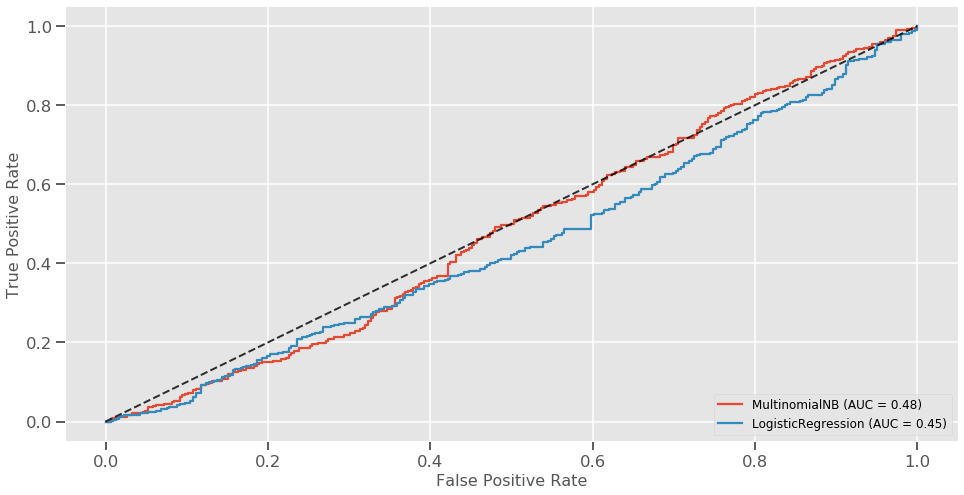

In [51]:
fig, ax = plt.subplots(1,1)

auroc_ax = metrics.plot_roc_curve(res_nbc_cv1.best_estimator_, X_test, y_test_c, ax=ax)
auroc_ax = metrics.plot_roc_curve(res_logreg_cv1.best_estimator_, X_test, y_test_c,  ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
        label='Chance', alpha=.8)
plt.show()

In [52]:
res_logreg_cv1.classes_

array([0, 1])

In [53]:
p_train = pd.Series(index=X_train.index, data=res_logreg_cv1.predict_proba(X_train)[:,1], name='sentiment_score')
p_test = pd.Series(index=X_test.index, data=res_logreg_cv1.predict_proba(X_test)[:,1], name='sentiment_score')

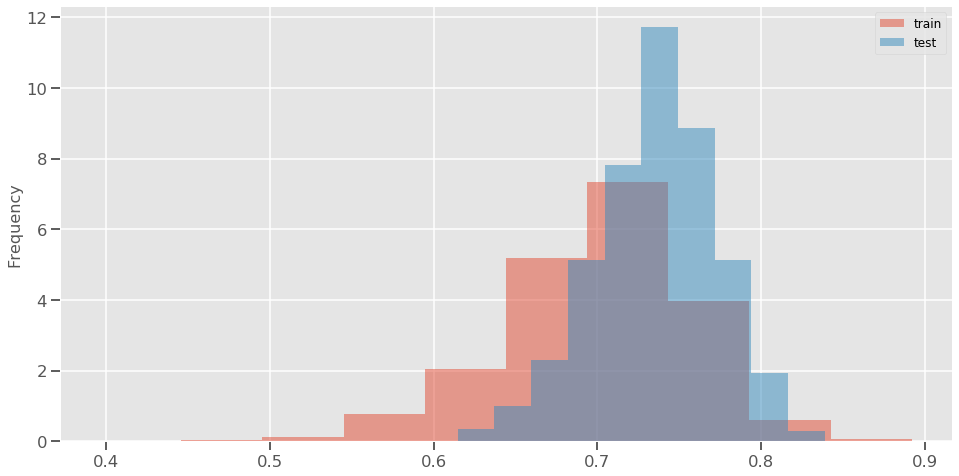

In [54]:
ax = p_train.plot.hist(density=True, alpha=0.5, label='train')
p_test.plot.hist(density=True, alpha=0.5, label='test', ax=ax)
plt.legend()
plt.show()

In [55]:
preds = pd.concat([p_train, p_test], axis=0).reset_index().merge(sector_to_asset, how='left', on='ticker').set_index(['date', 'ticker']).sort_index()
preds['sector_code'] = preds['sector_code'].fillna(-1)
preds['sector'] = preds['sector'].fillna("No sector")

In [56]:
sent_alphas = bow_sent.compute_sentiment_alpha_factor(sent_scores=preds, date_col='date', sector_col='sector_code', score_col='sentiment_score')

In [57]:
sent_alphas

date        ticker
1998-01-01  abt       0.307519
            adbe     -1.302434
            adi       0.904468
            adm      -1.664222
            adp      -1.356702
                        ...   
2017-01-01  xyl       0.042481
            yum      -0.637210
            zbh      -0.830304
            zion     -0.359155
            zts       0.482735
Name: sentiment_score, Length: 7255, dtype: float64

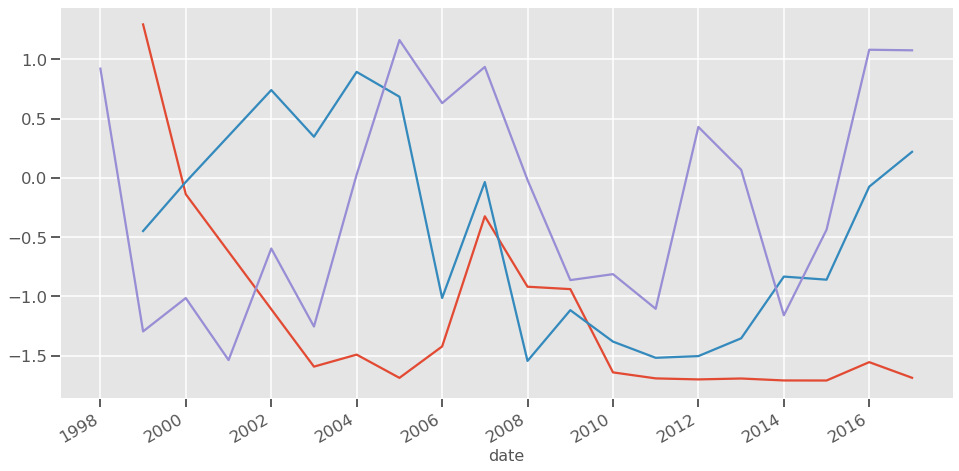

In [58]:
ax = sent_alphas.xs(key='amzn', level='ticker').plot()
sent_alphas.xs(key='aapl', level='ticker').plot(ax=ax)
sent_alphas.xs(key='msft', level='ticker').plot(ax=ax)
plt.show()

# Write Data

In [59]:
sent_alphas.to_csv(OUTPATH + OUTFILE1)